# Time Series Preprocessing Pipeline for Flight Delay Data

This notebook builds upon the base preprocessing pipeline to create features specifically optimized for time series models such as ARIMA, Prophet, and other forecasting algorithms. Time series analysis requires specific preprocessing steps including proper temporal aggregation, handling of seasonality, and preparation of lagged features.

## Key Processing Steps:
1. Loading the base preprocessed data
2. Temporal aggregation (daily, hourly)
3. Time series feature engineering (lags, rolling windows)
4. Handling seasonality
5. Stationarity testing and transformations
6. Creation of exogenous variables
7. Time-based train-test splits with forecast horizon
8. Exporting the processed data for time series model training

In [104]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import pickle

# Ignore warnings
warnings.filterwarnings('ignore')

# Configure paths dynamically using relative paths
import os.path as path

# Get the directory of the current notebook
notebook_dir = path.dirname(path.abspath('__file__'))
# Get project root (parent of notebooks directory)
project_root = path.abspath(path.join(notebook_dir, '..', '..'))

# Define paths relative to project root
BASE_PROCESSED_PATH = path.join(project_root, 'data', 'processed', 'base_preprocessed_flights.csv')
TS_PROCESSED_PATH = path.join(project_root, 'data', 'processed', 'ts_ready_flights')
TS_MODEL_PATH = path.join(project_root, 'models', 'ts')

# Create directories if they don't exist
os.makedirs(os.path.dirname(TS_PROCESSED_PATH), exist_ok=True)
os.makedirs(TS_MODEL_PATH, exist_ok=True)

print(f"Base processed data path: {BASE_PROCESSED_PATH}")
print(f"Time Series processed data path: {TS_PROCESSED_PATH}")
print(f"Time Series model path: {TS_MODEL_PATH}")

# Display settings
pd.set_option('display.max_columns', None)
print("Libraries and paths configured.")

Base processed data path: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\base_preprocessed_flights.csv
Time Series processed data path: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights
Time Series model path: c:\xampp\htdocs\Forecasting_Flights-DataScience\models\ts
Libraries and paths configured.


In [105]:
# Function to handle negative delays in any dataframe
def fix_negative_delays(df):
    """Set any negative delay values to zero"""
    delay_columns = ['DEP_DELAY', 'ARR_DELAY', 'avg_delay', 'median_delay', 'max_delay', 'min_delay']
    for col in delay_columns:
        if col in df.columns:
            df[col] = df[col].clip(lower=0)
    return df



In [106]:
# Function to load data in chunks
def load_processed_data(file_path, chunk_size=500000):
    """
    Generator function to load preprocessed data in chunks
    """
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        # Convert date columns to datetime
        date_columns = [col for col in chunk.columns if 'DATE' in col.upper()]
        for col in date_columns:
            chunk[col] = pd.to_datetime(chunk[col], errors='coerce')
        
        # Fix any negative delays in the chunk
        chunk = fix_negative_delays(chunk)
        
        yield chunk

In [107]:
# Inspect the data
first_chunk = next(load_processed_data(BASE_PROCESSED_PATH))

print(f"Data shape of first chunk: {first_chunk.shape}")
print("\nColumns and data types:")
for col in first_chunk.columns:
    print(f"- {col}: {first_chunk[col].dtype}")

print("\nSample data (first 5 rows):")
display(first_chunk.head())

Data shape of first chunk: (500000, 41)

Columns and data types:
- FL_DATE: datetime64[ns]
- AIRLINE: object
- AIRLINE_DOT: object
- AIRLINE_CODE: object
- DOT_CODE: int64
- FL_NUMBER: int64
- ORIGIN: object
- ORIGIN_CITY: object
- DEST: object
- DEST_CITY: object
- CRS_DEP_TIME: int64
- DEP_TIME: int64
- DEP_DELAY: float64
- TAXI_OUT: float64
- WHEELS_OFF: float64
- WHEELS_ON: float64
- TAXI_IN: float64
- CRS_ARR_TIME: int64
- ARR_TIME: float64
- ARR_DELAY: float64
- CANCELLED: int64
- CANCELLATION_CODE: float64
- DIVERTED: int64
- CRS_ELAPSED_TIME: float64
- ELAPSED_TIME: float64
- AIR_TIME: float64
- DISTANCE: float64
- DELAY_DUE_CARRIER: float64
- DELAY_DUE_WEATHER: float64
- DELAY_DUE_NAS: float64
- DELAY_DUE_SECURITY: float64
- DELAY_DUE_LATE_AIRCRAFT: float64
- YEAR: int64
- QUARTER: int64
- MONTH: int64
- DAY_OF_MONTH: int64
- DAY_OF_WEEK: int64
- SEASON: int64
- IS_HOLIDAY_SEASON: int64
- DEP_HOUR: int64
- TIME_OF_DAY: object

Sample data (first 5 rows):


,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,SEASON,IS_HOLIDAY_SEASON,DEP_HOUR,TIME_OF_DAY
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",715,711,0.0,19.0,1210.0,1443.0,4.0,901,1447.0,0.0,0,NaN,0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN,2019,1,1,9,2,1,0,11,Morning
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",1280,1274,0.0,9.0,2123.0,2232.0,38.0,1395,2310.0,0.0,0,NaN,0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN,2022,4,11,19,5,4,1,21,Evening
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",594,600,6.0,20.0,1020.0,1247.0,5.0,772,1252.0,0.0,0,NaN,0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN,2022,3,7,22,4,3,0,9,Morning
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",969,968,0.0,27.0,1635.0,1844.0,9.0,1109,1853.0,24.0,0,NaN,0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0,2023,1,3,6,0,2,0,16,Afternoon
4,2019-07-31,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,665,DAL,"Dallas, TX",OKC,"Oklahoma City, OK",610,757,147.0,15.0,1252.0,1328.0,3.0,670,1331.0,141.0,0,NaN,0,60.0,54.0,36.0,181.0,141.0,0.0,0.0,0.0,0.0,2019,3,7,31,2,3,0,10,Morning


In [108]:
# --- MISSING VALUE HANDLING FOR TS PIPELINE ---
def drop_columns_with_high_missing(df, threshold=0.5):
    """
    Drop columns with >= threshold proportion of missing values.
    """
    missing_ratio = df.isnull().mean(axis=0)
    cols_to_drop = missing_ratio[missing_ratio >= threshold].index.tolist()
    if cols_to_drop:
        print(f"Dropping columns with >= {int(threshold*100)}% missing values: {cols_to_drop}")
    return df.drop(columns=cols_to_drop)



In [109]:
# Check missing values in each column after dropping columns with high missingness
df_after_drop = drop_columns_with_high_missing(first_chunk, threshold=0.5)
missing_counts = df_after_drop.isnull().sum()
missing_percent = df_after_drop.isnull().mean() * 100

print("Missing values per column (after dropping high-missing columns):")
for col in df_after_drop.columns:
    print(f"- {col}: {missing_counts[col]} missing ({missing_percent[col]:.2f}%)")

Dropping columns with >= 50% missing values: ['CANCELLATION_CODE', 'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']
Missing values per column (after dropping high-missing columns):
- FL_DATE: 0 missing (0.00%)
- AIRLINE: 0 missing (0.00%)
- AIRLINE_DOT: 0 missing (0.00%)
- AIRLINE_CODE: 0 missing (0.00%)
- DOT_CODE: 0 missing (0.00%)
- FL_NUMBER: 0 missing (0.00%)
- ORIGIN: 0 missing (0.00%)
- ORIGIN_CITY: 0 missing (0.00%)
- DEST: 0 missing (0.00%)
- DEST_CITY: 0 missing (0.00%)
- CRS_DEP_TIME: 0 missing (0.00%)
- DEP_TIME: 0 missing (0.00%)
- DEP_DELAY: 0 missing (0.00%)
- TAXI_OUT: 0 missing (0.00%)
- WHEELS_OFF: 0 missing (0.00%)
- WHEELS_ON: 134 missing (0.03%)
- TAXI_IN: 134 missing (0.03%)
- CRS_ARR_TIME: 0 missing (0.00%)
- ARR_TIME: 134 missing (0.03%)
- ARR_DELAY: 1240 missing (0.25%)
- CANCELLED: 0 missing (0.00%)
- DIVERTED: 0 missing (0.00%)
- CRS_ELAPSED_TIME: 0 missing (0.00%)
- ELAPSED_TIME: 1240 missing (0.25%)

In [110]:
# Impute ARR_DELAY with DEP_DELAY where possible
if 'ARR_DELAY' in df_after_drop.columns and 'DEP_DELAY' in df_after_drop.columns:
    mask = df_after_drop['ARR_DELAY'].isna() & df_after_drop['DEP_DELAY'].notna()
    df_after_drop.loc[mask, 'ARR_DELAY'] = df_after_drop.loc[mask, 'DEP_DELAY']

# Impute numeric columns with median
numeric_cols = df_after_drop.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    df_after_drop[col].fillna(df_after_drop[col].median(), inplace=True)

# Impute categorical columns with mode
categorical_cols = df_after_drop.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    if df_after_drop[col].isnull().any():
        df_after_drop[col].fillna(df_after_drop[col].mode()[0], inplace=True)

# Store the imputed result in a new DataFrame
df_imputed = df_after_drop.copy()

# Optionally print a summary to verify the changes
print("Missing values after imputation:")
missing_counts = df_imputed.isnull().sum()
missing_percent = df_imputed.isnull().mean() * 100
for col in df_imputed.columns:
    print(f"- {col}: {missing_counts[col]} missing ({missing_percent[col]:.2f}%)")


Missing values after imputation:
- FL_DATE: 0 missing (0.00%)
- AIRLINE: 0 missing (0.00%)
- AIRLINE_DOT: 0 missing (0.00%)
- AIRLINE_CODE: 0 missing (0.00%)
- DOT_CODE: 0 missing (0.00%)
- FL_NUMBER: 0 missing (0.00%)
- ORIGIN: 0 missing (0.00%)
- ORIGIN_CITY: 0 missing (0.00%)
- DEST: 0 missing (0.00%)
- DEST_CITY: 0 missing (0.00%)
- CRS_DEP_TIME: 0 missing (0.00%)
- DEP_TIME: 0 missing (0.00%)
- DEP_DELAY: 0 missing (0.00%)
- TAXI_OUT: 0 missing (0.00%)
- WHEELS_OFF: 0 missing (0.00%)
- WHEELS_ON: 0 missing (0.00%)
- TAXI_IN: 0 missing (0.00%)
- CRS_ARR_TIME: 0 missing (0.00%)
- ARR_TIME: 0 missing (0.00%)
- ARR_DELAY: 0 missing (0.00%)
- CANCELLED: 0 missing (0.00%)
- DIVERTED: 0 missing (0.00%)
- CRS_ELAPSED_TIME: 0 missing (0.00%)
- ELAPSED_TIME: 0 missing (0.00%)
- AIR_TIME: 0 missing (0.00%)
- DISTANCE: 0 missing (0.00%)
- YEAR: 0 missing (0.00%)
- QUARTER: 0 missing (0.00%)
- MONTH: 0 missing (0.00%)
- DAY_OF_MONTH: 0 missing (0.00%)
- DAY_OF_WEEK: 0 missing (0.00%)
- SEASON:

## Time Series Pre-analysis



In [111]:
# Modify the aggregate_to_time_series function to handle non-chunked data
def aggregate_to_time_series(df, agg_level='daily', target_col='DEP_DELAY'):
    """
    Aggregate flight data into time series at different temporal resolutions
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame
    agg_level : str
        Level of aggregation ('daily', 'hourly', 'airport_daily', 'carrier_daily')
    target_col : str
        Column to aggregate (typically delay)
    
    Returns:
    --------
    pd.DataFrame
        Aggregated time series data
    """
    # Fix any negative delays before aggregation
    df = fix_negative_delays(df)
    
    # Ensure we have date information
    if 'FL_DATE' not in df.columns:
        print("Error: FL_DATE column not found")
        return None
    
    # Define groupby columns based on aggregation level
    if agg_level == 'daily':
        groupby_cols = ['FL_DATE']
    elif agg_level == 'hourly':
        if 'DEP_HOUR' in df.columns:
            df['DATETIME'] = df['FL_DATE'] + pd.to_timedelta(df['DEP_HOUR'], unit='h')
            groupby_cols = ['DATETIME']
        else:
            print("Error: DEP_HOUR column not found for hourly aggregation")
            return None
    elif agg_level == 'airport_daily':
        if 'ORIGIN' in df.columns:
            groupby_cols = ['FL_DATE', 'ORIGIN']
        else:
            print("Error: ORIGIN column not found for airport_daily aggregation")
            return None
    elif agg_level == 'carrier_daily':
        if 'OP_CARRIER' in df.columns:
            groupby_cols = ['FL_DATE', 'OP_CARRIER']
        else:
            print("Error: OP_CARRIER column not found for carrier_daily aggregation")
            return None
    else:
        print(f"Error: Unknown aggregation level: {agg_level}")
        return None
    
    # Skip chunk if target column is not present
    if target_col not in df.columns:
        print(f"Error: {target_col} column not found in the DataFrame")
        return None
    
    # Aggregate data
    agg = df.groupby(groupby_cols).agg(
        avg_delay=(target_col, 'mean'),
        median_delay=(target_col, 'median'),
        max_delay=(target_col, 'max'),
        min_delay=(target_col, 'min'),
        std_delay=(target_col, 'std'),
        num_flights=(target_col, 'count')
    )
    
    # Fix negative delays in aggregated data
    agg = fix_negative_delays(agg)
    
    # Sort by date and fix any remaining negative delays
    agg = agg.sort_index()
    agg = fix_negative_delays(agg)
    
    return agg




################# ts_daily #####################

Daily time series shape: (1338, 6)

First few rows:


,avg_delay,median_delay,max_delay,min_delay,std_delay,num_flights
FL_DATE,,,,,,
2019-01-01,13.567647,0.0,198.0,0.0,29.342221,340
2019-01-02,16.594406,0.0,386.0,0.0,41.435837,429
2019-01-03,13.640732,0.0,745.0,0.0,47.075057,437
2019-01-04,9.534442,0.0,668.0,0.0,41.242799,421
2019-01-05,11.402089,0.0,667.0,0.0,43.920981,383


Date range: 2019-01-01 00:00:00 to 2023-08-31 00:00:00
Total days: 1338


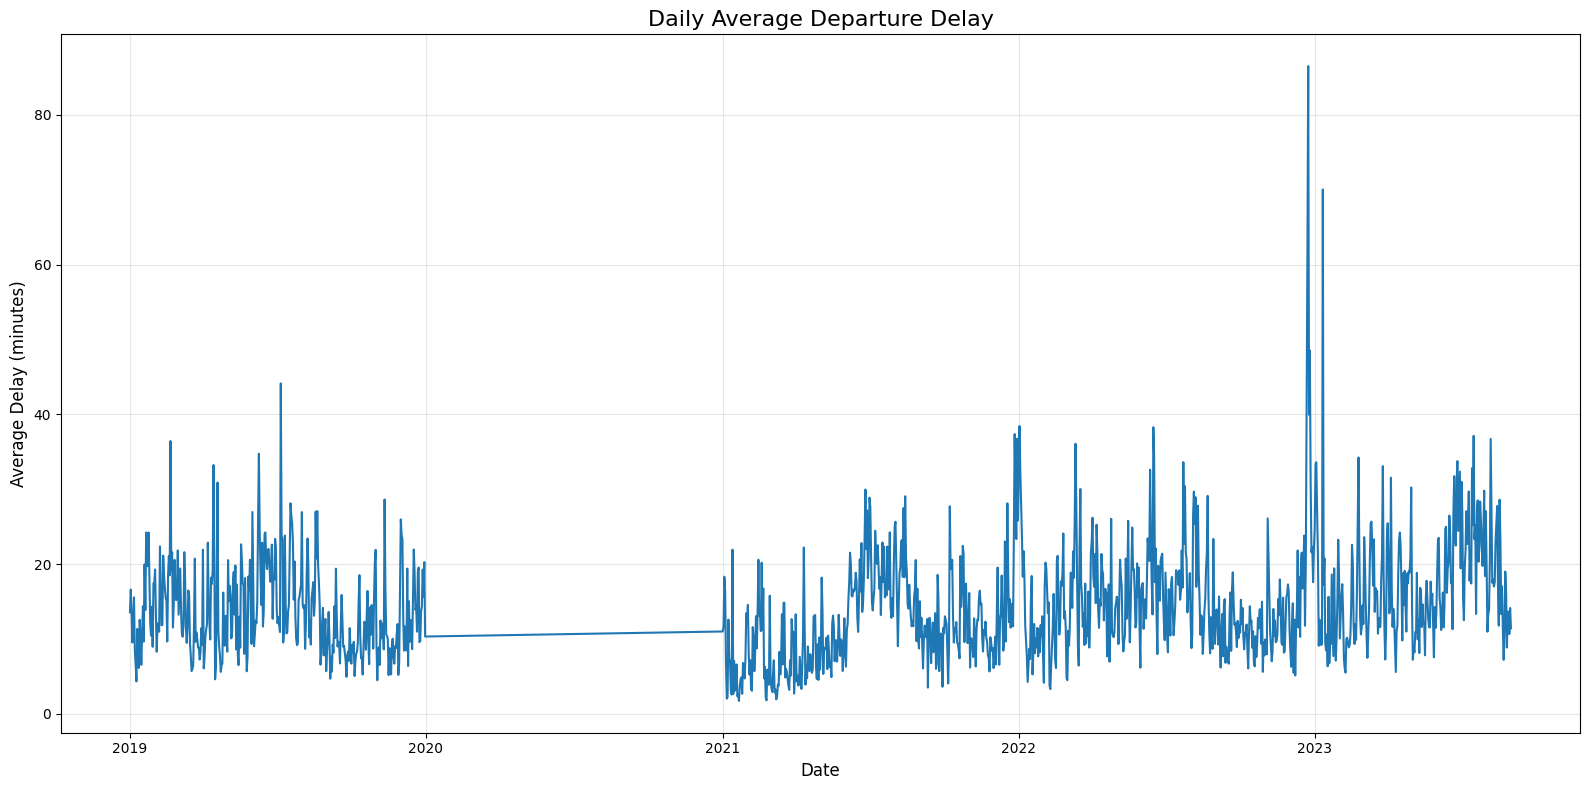

In [112]:
# Use df_imputed instead of processed data for aggregation
ts_daily = aggregate_to_time_series(df_imputed, agg_level='daily')

# Display the shape of the aggregated time series
print(f"Daily time series shape: {ts_daily.shape}")
print("\nFirst few rows:")
display(ts_daily.head())

# Check the date range of the aggregated time series
print(f"Date range: {ts_daily.index.min()} to {ts_daily.index.max()}")
print(f"Total days: {len(ts_daily)}")

# Plot the daily average delay
plt.figure(figsize=(16, 8))
plt.plot(ts_daily.index, ts_daily['avg_delay'], linewidth=1.5)
plt.title('Daily Average Departure Delay', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Delay (minutes)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [113]:
# Check for stationarity
def check_stationarity(ts, column='avg_delay'):
    """
    Check if a time series is stationary using the Augmented Dickey-Fuller test
    """
    # Calculate rolling statistics
    rolling_mean = ts[column].rolling(window=7).mean()
    rolling_std = ts[column].rolling(window=7).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(16, 8))
    plt.subplot(211)
    plt.plot(ts.index, ts[column], label='Original')
    plt.plot(ts.index, rolling_mean, label='Rolling Mean (7-day)')
    plt.plot(ts.index, rolling_std, label='Rolling Std (7-day)')
    plt.legend()
    plt.title('Rolling Mean & Standard Deviation', fontsize=16)
    plt.grid(True, alpha=0.3)
    
    # Perform ADF test
    result = adfuller(ts[column].dropna())
    
    plt.subplot(212)
    plt.bar(['ADF Statistic', 'p-value', '1%', '5%', '10%'], 
            [result[0], result[1], result[4]['1%'], result[4]['5%'], result[4]['10%']], 
            color=['blue', 'red', 'green', 'green', 'green'])
    plt.axhline(y=result[4]['5%'], color='green', linestyle='-', alpha=0.5)
    plt.title('Augmented Dickey-Fuller Test Results', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print test results
    print('Augmented Dickey-Fuller Test Results:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    
    # Interpret results
    if result[1] <= 0.05:
        print("\nConclusion: Time series is stationary (reject null hypothesis)")
        return True
    else:
        print("\nConclusion: Time series is non-stationary (fail to reject null hypothesis)")
        return False

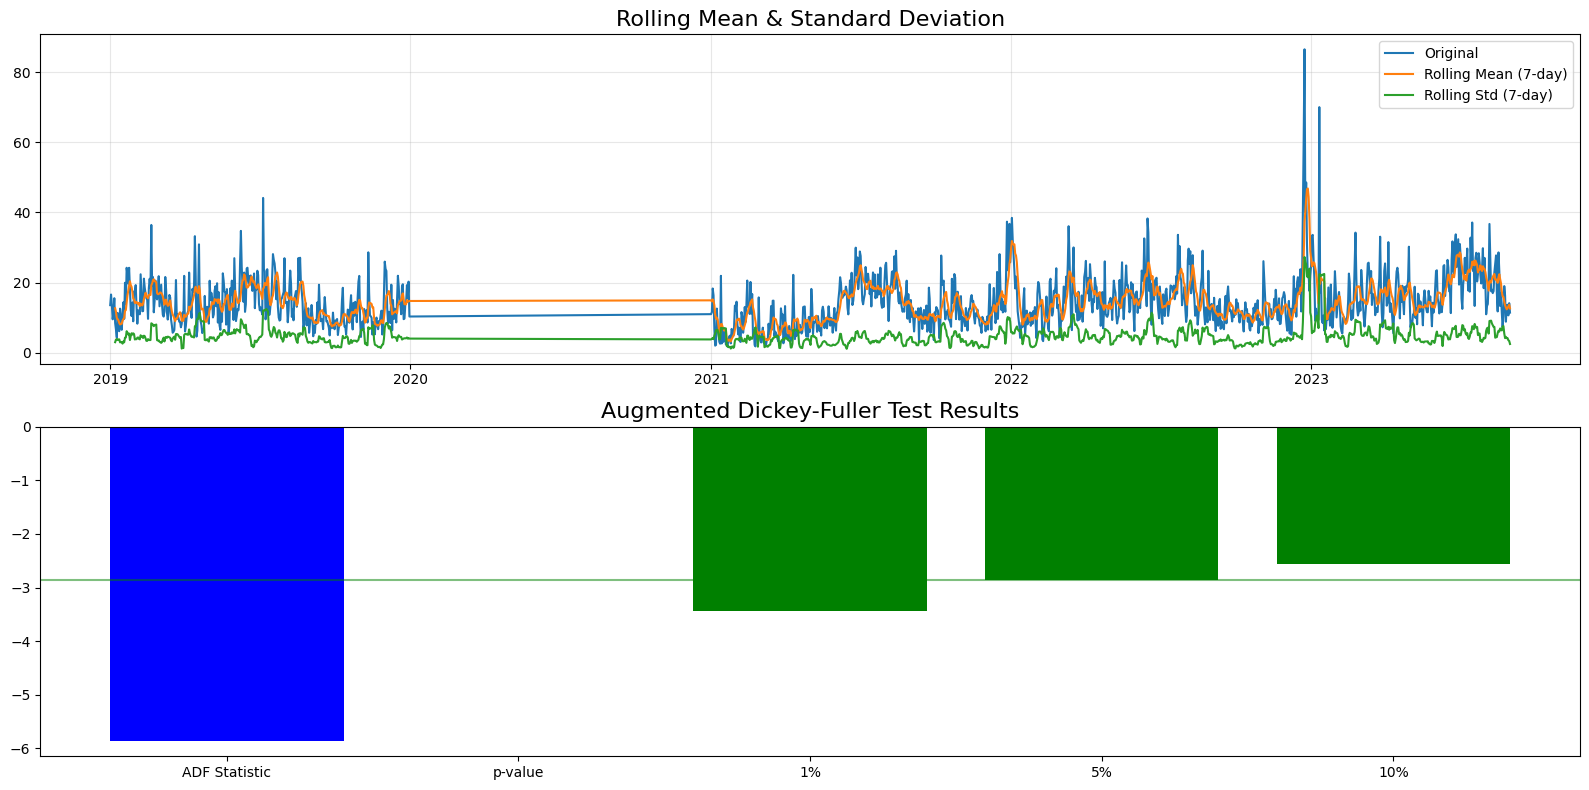

Augmented Dickey-Fuller Test Results:
ADF Statistic: -5.8577
p-value: 0.0000
Critical Values:
   1%: -3.4353
   5%: -2.8637
   10%: -2.5679

Conclusion: Time series is stationary (reject null hypothesis)


In [114]:
# Check stationarity of the daily average delay time series
is_stationary = check_stationarity(ts_daily)

# If not stationary, demonstrate differencing
if not is_stationary:
    # First-order differencing
    ts_daily['diff1'] = ts_daily['avg_delay'].diff().dropna()
    
    # Check stationarity of differenced series
    print("\nChecking stationarity after first-order differencing:")
    is_stationary_diff1 = check_stationarity(ts_daily.dropna(), column='diff1')

In [115]:
# Seasonal decomposition
def decompose_time_series(ts, column='avg_delay'):
    """
    Decompose time series into trend, seasonal, and residual components
    """
    # Fill any missing values with forward fill
    ts_filled = ts[column].fillna(method='ffill')
    
    # Check if we have enough data for decomposition
    if len(ts_filled) < 14:  # Need at least twice the period for weekly seasonality
        print("Not enough data for decomposition")
        return None
    
    # Perform seasonal decomposition with additive model
    try:
        decomposition = seasonal_decompose(ts_filled, model='additive', period=7)  # Weekly seasonality
        
        # Plot decomposition
        plt.figure(figsize=(16, 12))
        
        plt.subplot(411)
        plt.plot(decomposition.observed)
        plt.title('Observed', fontsize=16)
        plt.grid(True, alpha=0.3)
        
        plt.subplot(412)
        plt.plot(decomposition.trend)
        plt.title('Trend', fontsize=16)
        plt.grid(True, alpha=0.3)
        
        plt.subplot(413)
        plt.plot(decomposition.seasonal)
        plt.title('Seasonality (Weekly)', fontsize=16)
        plt.grid(True, alpha=0.3)
        
        plt.subplot(414)
        plt.plot(decomposition.resid)
        plt.title('Residuals', fontsize=16)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return decomposition
    except Exception as e:
        print(f"Error during decomposition: {e}")
        return None

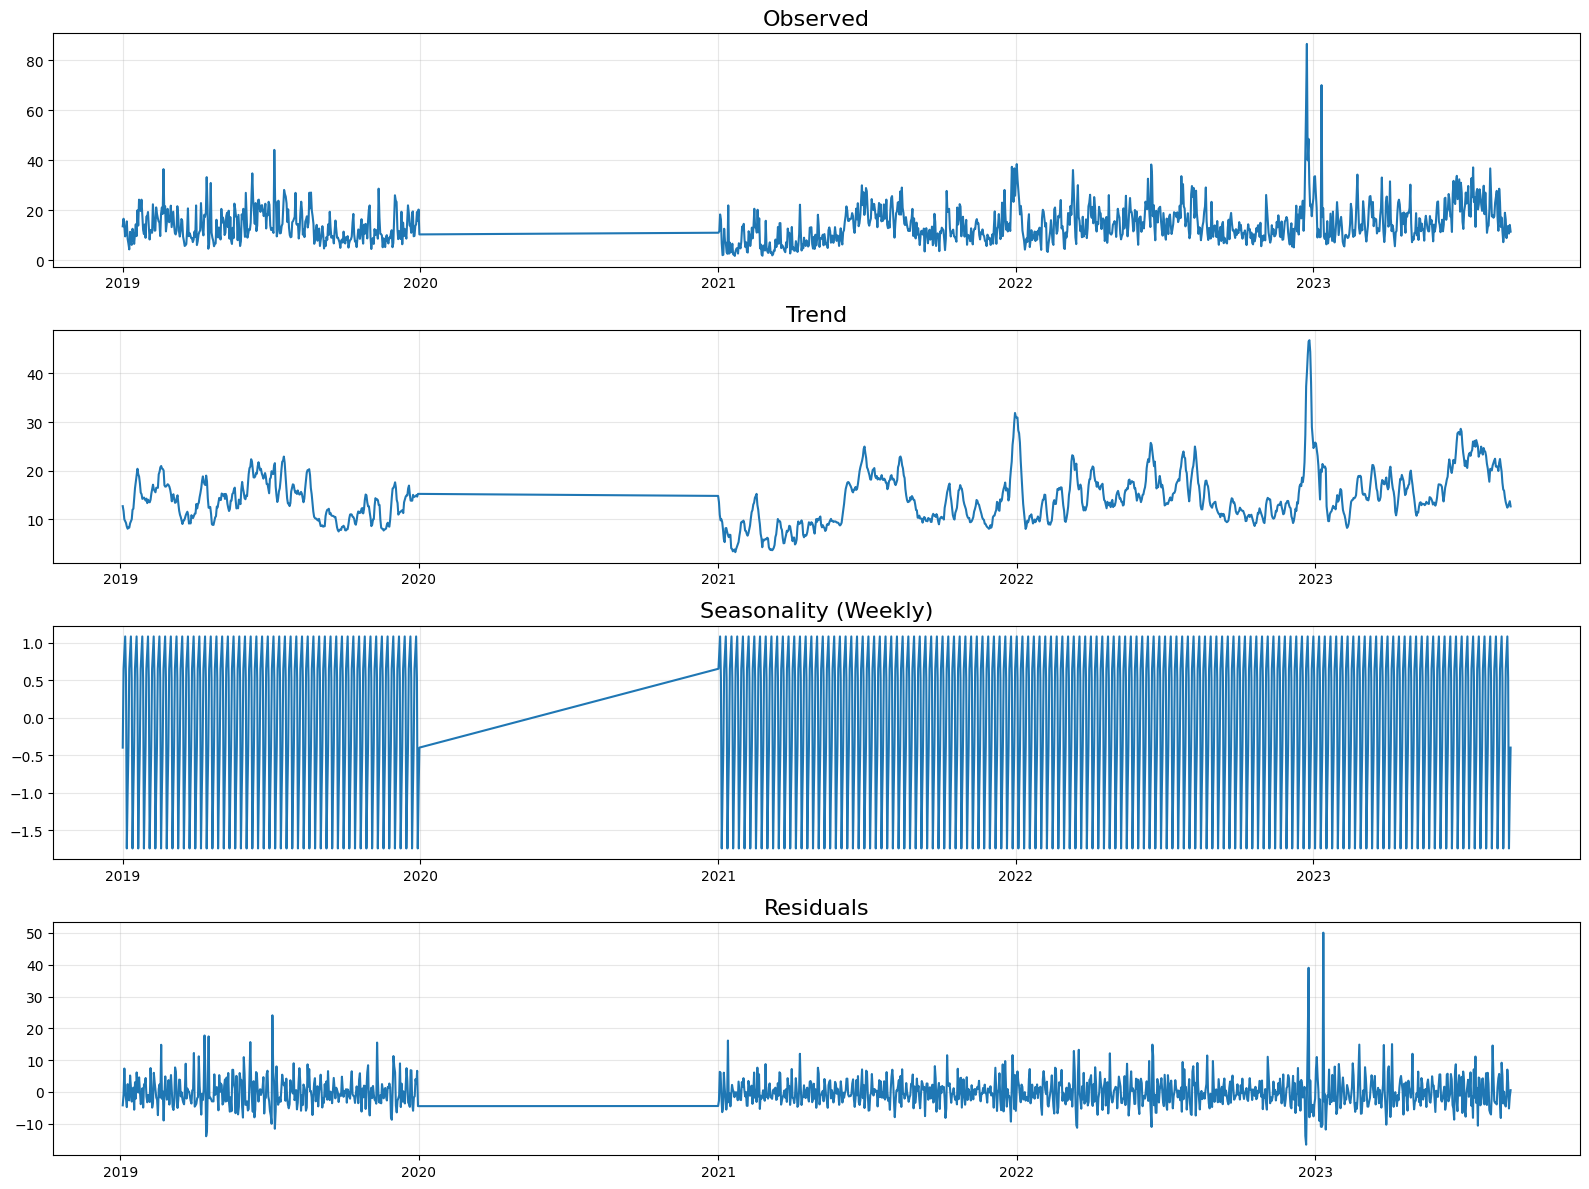

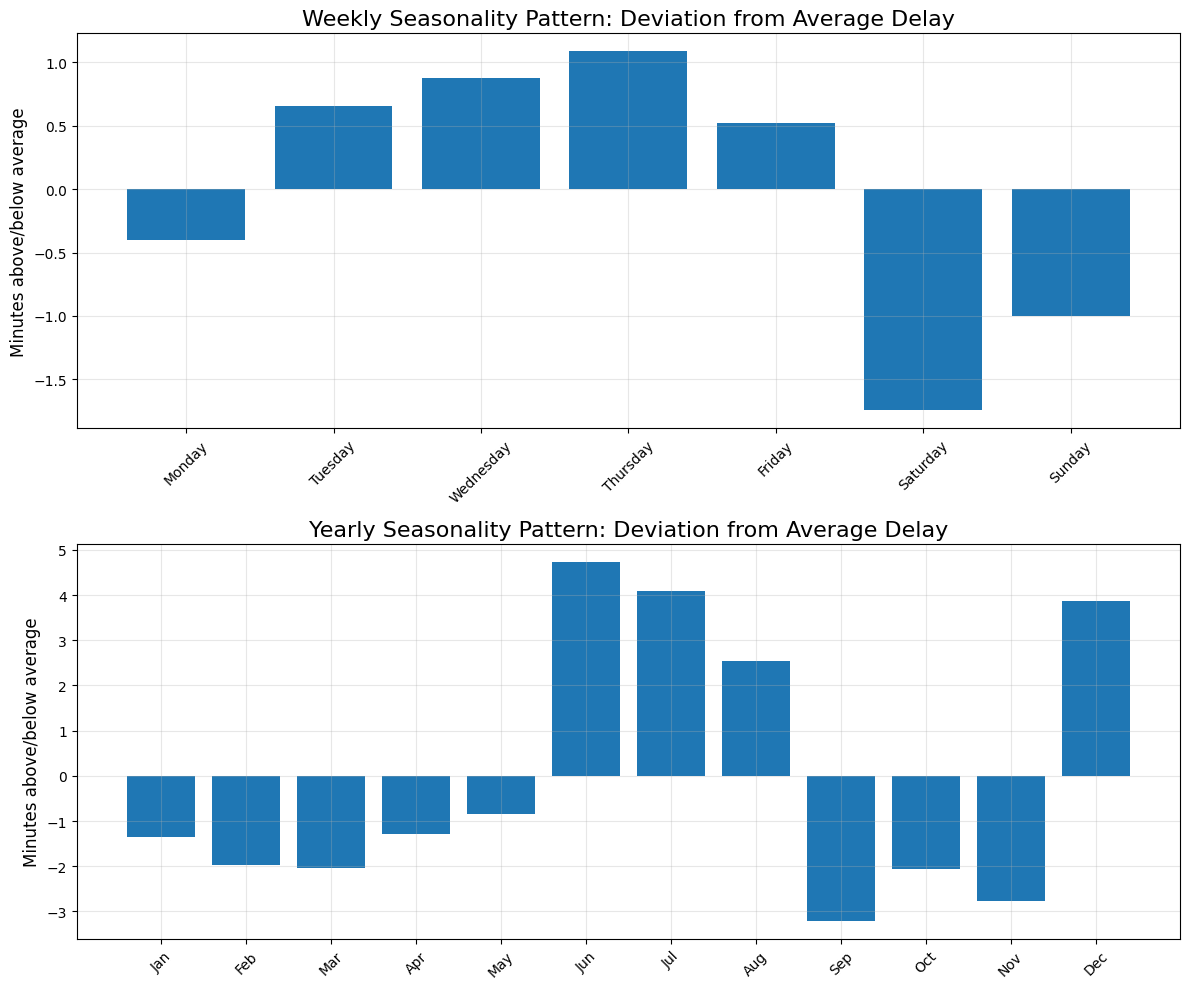


Seasonality Summary (showing deviations from average delay):

Weekly Pattern (minutes above/below average):
Monday: -0.40 minutes
Tuesday: +0.65 minutes
Wednesday: +0.88 minutes
Thursday: +1.09 minutes
Friday: +0.52 minutes
Saturday: -1.74 minutes
Sunday: -1.00 minutes

Yearly Pattern (minutes above/below average):
Jan: -1.35 minutes
Feb: -1.97 minutes
Mar: -2.04 minutes
Apr: -1.28 minutes
May: -0.84 minutes
Jun: +4.73 minutes
Jul: +4.10 minutes
Aug: +2.55 minutes
Sep: -3.21 minutes
Oct: -2.05 minutes
Nov: -2.77 minutes
Dec: +3.87 minutes


In [116]:
# Decompose the time series to understand seasonality patterns
# First decompose with weekly seasonality
decomposition_weekly = decompose_time_series(ts_daily)

# Then decompose with yearly seasonality (period=365)
# Fill missing values and resample to daily frequency if needed
ts_daily_filled = ts_daily['avg_delay'].fillna(method='ffill').fillna(method='bfill')
decomposition_yearly = seasonal_decompose(ts_daily_filled, period=365, model='additive')

# Analyze both weekly and yearly seasonality patterns
if decomposition_weekly is not None:
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # 1. Weekly Seasonality Plot
    seasonal_pattern_weekly = decomposition_weekly.seasonal[:7]
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    ax1.bar(days, seasonal_pattern_weekly)
    ax1.set_title('Weekly Seasonality Pattern: Deviation from Average Delay', fontsize=16)
    ax1.set_ylabel('Minutes above/below average', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Yearly Seasonality Plot
    # Extract monthly averages from the yearly seasonal component
    seasonal_pattern_yearly = pd.Series(decomposition_yearly.seasonal).groupby(pd.Grouper(freq='M')).mean()
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    ax2.bar(months, seasonal_pattern_yearly[:12])  # Plot first 12 months
    ax2.set_title('Yearly Seasonality Pattern: Deviation from Average Delay', fontsize=16)
    ax2.set_ylabel('Minutes above/below average', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics with clearer labeling
    print("\nSeasonality Summary (showing deviations from average delay):")
    print("\nWeekly Pattern (minutes above/below average):")
    for day, effect in zip(days, seasonal_pattern_weekly):
        print(f"{day}: {effect:+.2f} minutes")
    
    print("\nYearly Pattern (minutes above/below average):")
    for month, effect in zip(months, seasonal_pattern_yearly[:12]):
        print(f"{month}: {effect:+.2f} minutes")

In [117]:
# Analyze ACF and PACF plots for time series modeling
def analyze_acf_pacf(ts, column='avg_delay', lags=40):
    """
    Analyze auto-correlation and partial auto-correlation functions
    """
    # Fill missing values
    ts_filled = ts[column].fillna(method='ffill')
    
    # Create the plots
    plt.figure(figsize=(16, 8))
    
    plt.subplot(211)
    plot_acf(ts_filled, lags=lags, alpha=0.05, title='Autocorrelation Function (ACF)', ax=plt.gca())
    plt.grid(True, alpha=0.3)
    
    plt.subplot(212)
    plot_pacf(ts_filled, lags=lags, alpha=0.05, method='ols', title='Partial Autocorrelation Function (PACF)', ax=plt.gca())
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

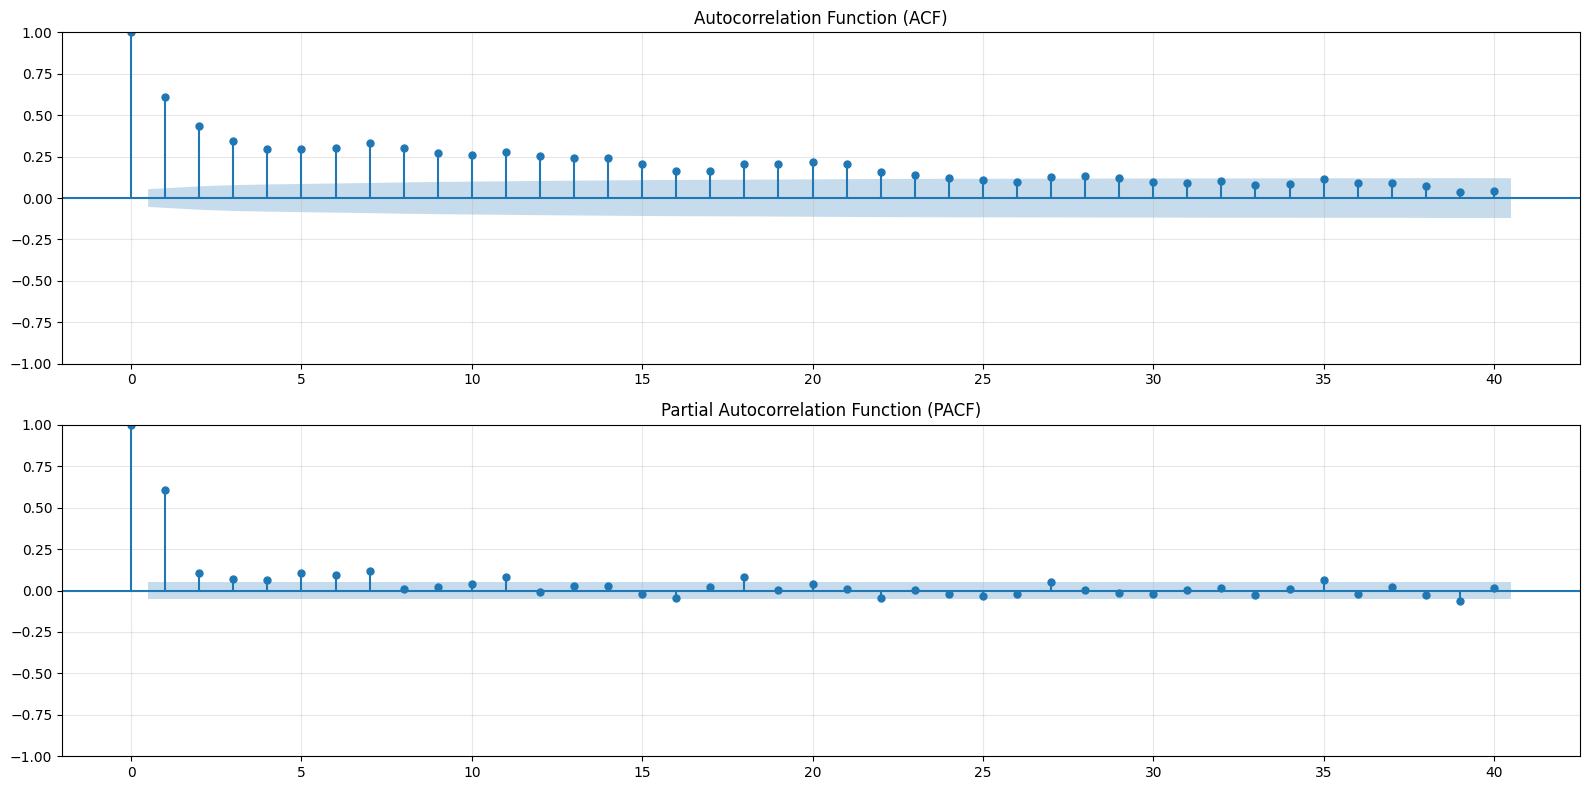

In [118]:
# Analyze ACF and PACF to guide model selection
analyze_acf_pacf(ts_daily)

####################### ts_hourly #########################

Hourly time series shape: (26520, 6)

First few rows:


,avg_delay,median_delay,max_delay,min_delay,std_delay,num_flights
DATETIME,,,,,,
2019-01-01 02:00:00,6.000000,6.0,6.0,6.0,NaN,1
2019-01-01 05:00:00,18.285714,0.0,119.0,0.0,44.537304,7
2019-01-01 06:00:00,11.360000,0.0,198.0,0.0,39.406937,25
2019-01-01 07:00:00,3.428571,0.0,26.0,0.0,7.242730,21
2019-01-01 08:00:00,6.321429,0.0,81.0,0.0,16.830426,28


Date range: 2019-01-01 02:00:00 to 2023-08-31 23:00:00
Total hours: 26520


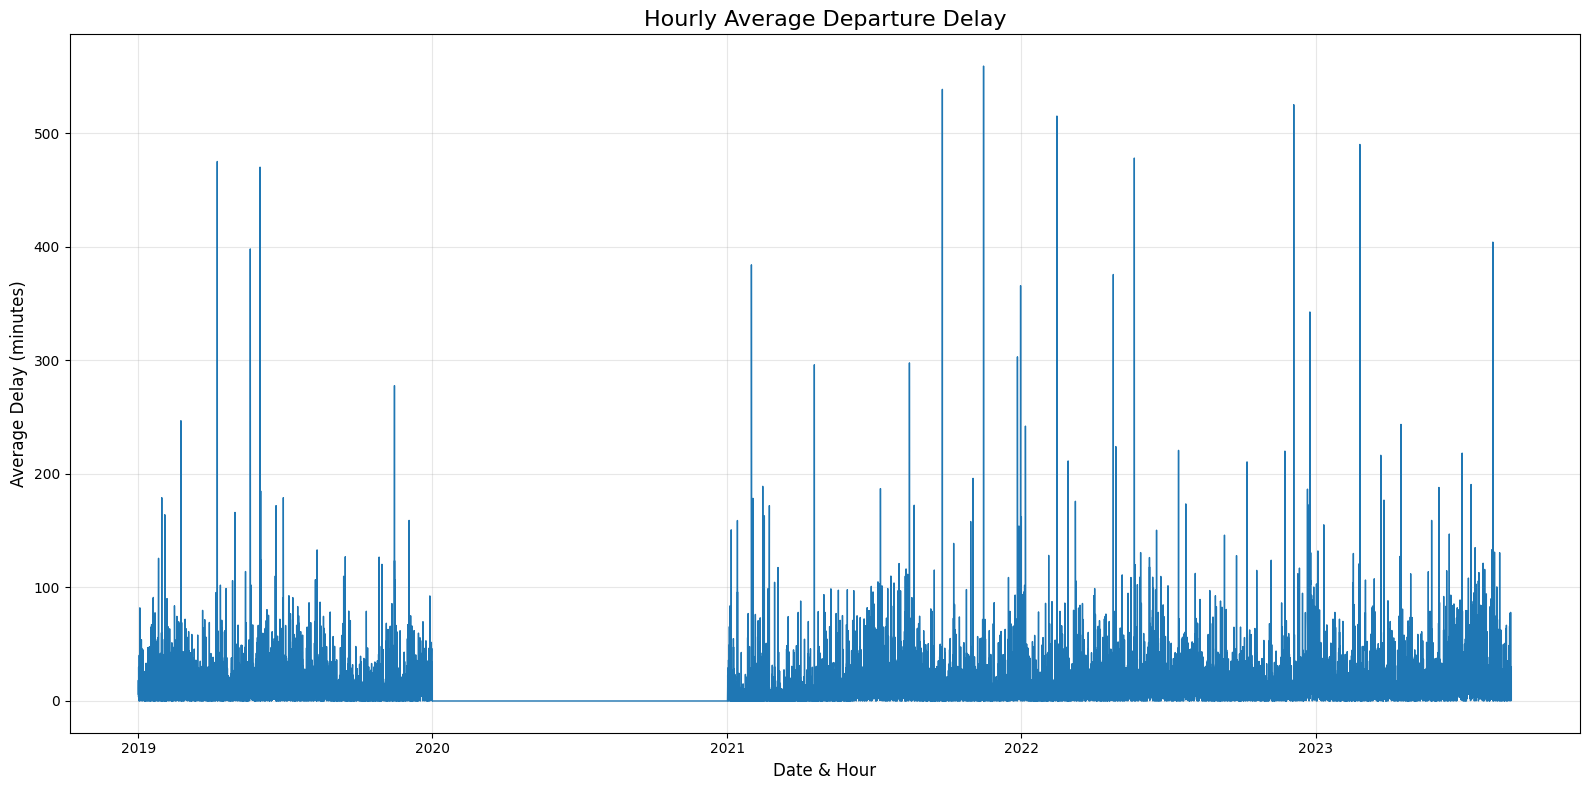

In [119]:
# Create and analyze hourly aggregated time series
ts_hourly = aggregate_to_time_series(df_imputed, agg_level='hourly')

print(f"Hourly time series shape: {ts_hourly.shape}")
print("\nFirst few rows:")
display(ts_hourly.head())  # Shows only first few rows

# Check the date range
print(f"Date range: {ts_hourly.index.min()} to {ts_hourly.index.max()}")
print(f"Total hours: {len(ts_hourly)}")

# Plot the time series
plt.figure(figsize=(16, 8))
plt.plot(ts_hourly.index, ts_hourly['avg_delay'], linewidth=1.0)
plt.title('Hourly Average Departure Delay', fontsize=16)
plt.xlabel('Date & Hour', fontsize=12)
plt.ylabel('Average Delay (minutes)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


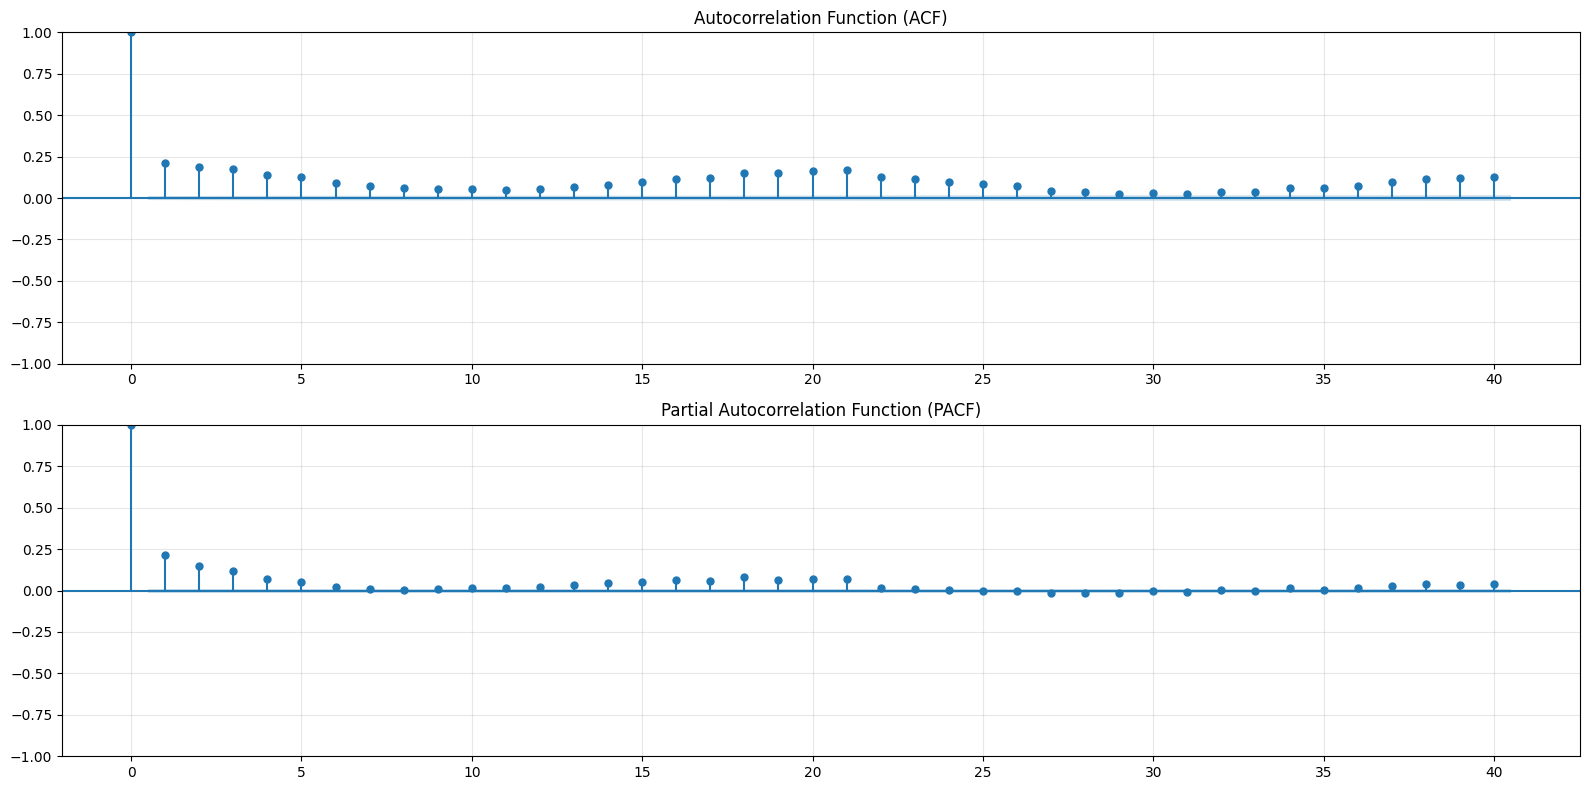

In [120]:
# Analyze ACF and PACF to guide model selection
analyze_acf_pacf(ts_hourly)

In [121]:
def aggregate_airport_daily(df, target_col='DEP_DELAY'):
    """
    Aggregate flight data into daily time series per airport.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame
    target_col : str
        Column to aggregate (typically delay)
    
    Returns:
    --------
    pd.DataFrame
        Aggregated time series data per airport and day
    """
    # Fix any negative delays before aggregation
    df = fix_negative_delays(df)
    
    # Ensure we have date and airport information
    if 'FL_DATE' not in df.columns or 'ORIGIN' not in df.columns:
        print("Error: FL_DATE or ORIGIN column not found")
        return None
    
    # Aggregate data by FL_DATE and ORIGIN (Airport)
    agg = df.groupby(['FL_DATE', 'ORIGIN']).agg(
        avg_delay=(target_col, 'mean'),
        median_delay=(target_col, 'median'),
        max_delay=(target_col, 'max'),
        min_delay=(target_col, 'min'),
        std_delay=(target_col, 'std'),
        num_flights=(target_col, 'count')
    )
    
    # Include other numeric columns (e.g., delays) in the aggregation
    for col in df.select_dtypes(include=['number']).columns:  # Only numeric columns
        if col != target_col:
            agg[f'{col}_mean'] = df.groupby(['FL_DATE', 'ORIGIN'])[col].mean()
            agg[f'{col}_median'] = df.groupby(['FL_DATE', 'ORIGIN'])[col].median()
            agg[f'{col}_max'] = df.groupby(['FL_DATE', 'ORIGIN'])[col].max()
            agg[f'{col}_min'] = df.groupby(['FL_DATE', 'ORIGIN'])[col].min()
            agg[f'{col}_std'] = df.groupby(['FL_DATE', 'ORIGIN'])[col].std()

    # Handle non-numeric columns
    for col in df.select_dtypes(exclude=['number']).columns:  # Non-numeric columns
        if col not in ['FL_DATE', 'ORIGIN']:
            agg[f'{col}_mode'] = df.groupby(['FL_DATE', 'ORIGIN'])[col].apply(lambda x: x.mode()[0] if not x.mode().empty else None)
            agg[f'{col}_count'] = df.groupby(['FL_DATE', 'ORIGIN'])[col].apply(lambda x: x.count())
    
    # Fix negative delays in aggregated data
    agg = fix_negative_delays(agg)
    
    # Sort by FL_DATE and ORIGIN
    agg = agg.sort_index()
    
    return agg


def aggregate_airport_hourly(df, target_col='DEP_DELAY'):
    """
    Aggregate flight data into hourly time series per airport.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame
    target_col : str
        Column to aggregate (typically delay)
    
    Returns:
    --------
    pd.DataFrame
        Aggregated time series data per airport and hour
    """
    # Fix any negative delays before aggregation
    df = fix_negative_delays(df)
    
    # Ensure we have date, airport, and hour information
    if 'FL_DATE' not in df.columns or 'ORIGIN' not in df.columns or 'DEP_HOUR' not in df.columns:
        print("Error: FL_DATE, ORIGIN, or DEP_HOUR column not found")
        return None
    
    # Add a new datetime column for hourly aggregation
    df['DATETIME'] = df['FL_DATE'] + pd.to_timedelta(df['DEP_HOUR'], unit='h')
    
    # Aggregate data by DATETIME and ORIGIN (Airport)
    agg = df.groupby(['DATETIME', 'ORIGIN']).agg(
        avg_delay=(target_col, 'mean'),
        median_delay=(target_col, 'median'),
        max_delay=(target_col, 'max'),
        min_delay=(target_col, 'min'),
        std_delay=(target_col, 'std'),
        num_flights=(target_col, 'count')
    )
    
    # Include other numeric columns (e.g., delays) in the aggregation
    for col in df.select_dtypes(include=['number']).columns:  # Only numeric columns
        if col != target_col:
            agg[f'{col}_mean'] = df.groupby(['DATETIME', 'ORIGIN'])[col].mean()
            agg[f'{col}_median'] = df.groupby(['DATETIME', 'ORIGIN'])[col].median()
            agg[f'{col}_max'] = df.groupby(['DATETIME', 'ORIGIN'])[col].max()
            agg[f'{col}_min'] = df.groupby(['DATETIME', 'ORIGIN'])[col].min()
            agg[f'{col}_std'] = df.groupby(['DATETIME', 'ORIGIN'])[col].std()

    # Handle non-numeric columns
    for col in df.select_dtypes(exclude=['number']).columns:  # Non-numeric columns
        if col not in ['FL_DATE', 'ORIGIN', 'DEP_HOUR']:
            agg[f'{col}_mode'] = df.groupby(['DATETIME', 'ORIGIN'])[col].apply(lambda x: x.mode()[0] if not x.mode().empty else None)
            agg[f'{col}_count'] = df.groupby(['DATETIME', 'ORIGIN'])[col].apply(lambda x: x.count())
    
    # Fix negative delays in aggregated data
    agg = fix_negative_delays(agg)
    
    # Sort by DATETIME and ORIGIN
    agg = agg.sort_index()
    
    return agg


In [122]:
def check_unique_values_in_cat_columns(df):
    """
    Check the number of unique values in each categorical column.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame containing the data.
    
    Returns:
    --------
    dict
        A dictionary where the keys are the categorical column names and the values are the number of unique values.
    """
    # Select categorical columns (object dtype)
    cat_columns = df.select_dtypes(include=['object', 'category']).columns
    
    # Create a dictionary to store the count of unique values for each categorical column
    unique_values_dict = {}
    
    for col in cat_columns:
        unique_values_dict[col] = df[col].nunique()  # Count unique values in the column
    
    return unique_values_dict

# Example usage:
unique_values = check_unique_values_in_cat_columns(df_imputed)
print("\nUnique values in each categorical column:")
print(unique_values)



Unique values in each categorical column:
{'AIRLINE': 18, 'AIRLINE_DOT': 18, 'AIRLINE_CODE': 18, 'ORIGIN': 379, 'ORIGIN_CITY': 372, 'DEST': 377, 'DEST_CITY': 370, 'TIME_OF_DAY': 4}


## Feature Engineering for Time Series Models

Based on our analysis, we'll create features specifically designed for time series forecasting. These include:
1. Lag features
2. Rolling statistics
3. Seasonal indicators
4. Holiday indicators
5. External regressors (e.g., weather data, if available)

In [123]:
# Create time series features for forecasting
def create_ts_features(ts_data):
    """
    Create features for time series forecasting
    """
    # Fix any negative delays before feature creation
    ts_data = fix_negative_delays(ts_data)
    
    # Make a copy to avoid modifying the original data
    ts = ts_data.copy()
    
    # ======== LAG FEATURES ========
    # Create lags of the target variable (useful for autoregressive models)
    for lag in [1, 2, 3, 7, 14, 21, 28]:  # Daily, weekly, and monthly lags
        ts[f'avg_delay_lag{lag}'] = ts['avg_delay'].shift(lag)
    
    # ======== ROLLING WINDOW FEATURES ========
    # Create rolling statistics
    for window in [3, 7, 14, 28]:
        ts[f'avg_delay_roll_mean{window}'] = ts['avg_delay'].rolling(window=window).mean()
        ts[f'avg_delay_roll_std{window}'] = ts['avg_delay'].rolling(window=window).std()
        ts[f'avg_delay_roll_max{window}'] = ts['avg_delay'].rolling(window=window).max()
        ts[f'avg_delay_roll_min{window}'] = ts['avg_delay'].rolling(window=window).min()
    
    # ======== CALENDAR FEATURES ========
    # Extract date components
    if isinstance(ts.index, pd.DatetimeIndex):
        # Add calendar features
        ts['month'] = ts.index.month
        ts['day_of_week'] = ts.index.dayofweek  # 0=Monday, 6=Sunday
        ts['day_of_year'] = ts.index.dayofyear
        ts['quarter'] = ts.index.quarter
        ts['week_of_year'] = ts.index.isocalendar().week
        
        # Add cyclical encoding of calendar features
        ts['month_sin'] = np.sin(2 * np.pi * ts['month'] / 12)
        ts['month_cos'] = np.cos(2 * np.pi * ts['month'] / 12)
        ts['day_of_week_sin'] = np.sin(2 * np.pi * ts['day_of_week'] / 7)
        ts['day_of_week_cos'] = np.cos(2 * np.pi * ts['day_of_week'] / 7)
        
        # Create weekend indicator
        ts['is_weekend'] = (ts['day_of_week'] >= 5).astype(int)
    
    # ======== TREND FEATURES ========
    # Create a simple trend feature (days since start)
    if isinstance(ts.index, pd.DatetimeIndex):
        ts['trend'] = (ts.index - ts.index.min()).days
    
    # Fix any negative delays that might have been introduced
    ts = fix_negative_delays(ts)
    
    return ts

In [124]:

def add_holiday_indicators(ts_data):
    """
    Add holiday indicators to the time series data using FL_DATE column.
    """
    # Make a copy to avoid modifying the original data
    ts = ts_data.copy()
    
    # Check that FL_DATE is a datetime column
    if not pd.api.types.is_datetime64_any_dtype(ts['FL_DATE']):
        print("Error: FL_DATE is not a datetime column")
        return ts
    
    # Initialize holiday columns
    ts['is_holiday'] = 0
    ts['is_holiday_season'] = 0
    
    # Get years in the data
    years = ts['FL_DATE'].dt.year.unique()
    
    # Define major US holidays (simplified version)
    holidays = []
    for year in years:
        # New Year's Day
        holidays.append(pd.Timestamp(year=year, month=1, day=1))
        
        # Memorial Day (last Monday in May)
        memorial_day = pd.Timestamp(year=year, month=5, day=31)
        memorial_day = memorial_day - pd.Timedelta(days=(memorial_day.dayofweek - 0) % 7)
        holidays.append(memorial_day)
        
        # Independence Day
        holidays.append(pd.Timestamp(year=year, month=7, day=4))
        
        # Labor Day (first Monday in September)
        labor_day = pd.Timestamp(year=year, month=9, day=1)
        labor_day = labor_day + pd.Timedelta(days=(0 - labor_day.dayofweek) % 7)
        holidays.append(labor_day)
        
        # Thanksgiving (fourth Thursday in November)
        thanksgiving = pd.Timestamp(year=year, month=11, day=1)
        thanksgiving = thanksgiving + pd.Timedelta(days=(3 - thanksgiving.dayofweek) % 7 + 21)
        holidays.append(thanksgiving)
        
        # Christmas
        holidays.append(pd.Timestamp(year=year, month=12, day=25))
    
    # Mark holidays
    for holiday in holidays:
        # Mark the actual holiday
        ts.loc[ts['FL_DATE'] == holiday, 'is_holiday'] = 1
        
        # Mark days before and after as holiday-adjacent (for travel effects)
        for i in range(1, 3):  # 1-2 days before and after
            before = holiday - pd.Timedelta(days=i)
            after = holiday + pd.Timedelta(days=i)
            
            ts.loc[ts['FL_DATE'] == before, 'is_holiday'] = 0.5  # Half weight for adjacent days
            ts.loc[ts['FL_DATE'] == after, 'is_holiday'] = 0.5  # Half weight for adjacent days
    
    # Mark holiday seasons (Nov 15 - Jan 15)
    for year in years:
        # Thanksgiving to New Year's season
        season_start = pd.Timestamp(year=year, month=11, day=15)
        season_end = pd.Timestamp(year=year+1, month=1, day=15)
        
        # Mark the holiday season
        mask = (ts['FL_DATE'] >= season_start) & (ts['FL_DATE'] <= season_end)
        ts.loc[mask, 'is_holiday_season'] = 1
    
    return ts


In [125]:
def create_new_ts_features(ts_data):
    """
    Create features for time series forecasting using DEP_DELAY for lag features
    """
    # Fix any negative delays before feature creation
    ts_data = fix_negative_delays(ts_data)
    
    # Make a copy to avoid modifying the original data
    ts = ts_data.copy()
    
    # ======== LAG FEATURES ========
    # Create lags of DEP_DELAY (useful for autoregressive models)
    for lag in [1, 2, 3, 7, 14, 21, 28]:  # Daily, weekly, and monthly lags
        ts[f'DEP_DELAY_lag{lag}'] = ts['DEP_DELAY'].shift(lag)
    
    # ======== ROLLING WINDOW FEATURES ========
    # Create rolling statistics
    for window in [3, 7, 14, 28]:
        ts[f'DEP_DELAY_roll_mean{window}'] = ts['DEP_DELAY'].rolling(window=window).mean()
        ts[f'DEP_DELAY_roll_std{window}'] = ts['DEP_DELAY'].rolling(window=window).std()
        ts[f'DEP_DELAY_roll_max{window}'] = ts['DEP_DELAY'].rolling(window=window).max()
        ts[f'DEP_DELAY_roll_min{window}'] = ts['DEP_DELAY'].rolling(window=window).min()
    
    # ======== CALENDAR FEATURES ========
    # Extract date components
    if isinstance(ts.index, pd.DatetimeIndex):
        # Add calendar features
        ts['month'] = ts.index.month
        ts['day_of_week'] = ts.index.dayofweek  # 0=Monday, 6=Sunday
        ts['day_of_year'] = ts.index.dayofyear
        ts['quarter'] = ts.index.quarter
        ts['week_of_year'] = ts.index.isocalendar().week
        
        # Add cyclical encoding of calendar features
        ts['month_sin'] = np.sin(2 * np.pi * ts['month'] / 12)
        ts['month_cos'] = np.cos(2 * np.pi * ts['month'] / 12)
        ts['day_of_week_sin'] = np.sin(2 * np.pi * ts['day_of_week'] / 7)
        ts['day_of_week_cos'] = np.cos(2 * np.pi * ts['day_of_week'] / 7)
        
        # Create weekend indicator
        ts['is_weekend'] = (ts['day_of_week'] >= 5).astype(int)
    
    # ======== TREND FEATURES ========
    # Create a simple trend feature (days since start)
    if isinstance(ts.index, pd.DatetimeIndex):
        ts['trend'] = (ts.index - ts.index.min()).days
    
    # Fix any negative delays that might have been introduced
    ts = fix_negative_delays(ts)
    
    return ts



Full per-flight dataset size after dropping full duplicates: 2470267 rows
Train set: 1345180 rows from 2019-01-01 00:00:00 to 2021-12-31 00:00:00
Test set: 1125087 rows from 2022-01-01 00:00:00 to 2023-08-31 00:00:00
Final per-flight delay output shape: (2470267, 2)


,FL_DATE,DEP_DELAY
0,2019-01-01,0.0
1,2019-01-01,29.0
2,2019-01-01,0.0
3,2019-01-01,7.0
4,2019-01-01,0.0


Saved per_flight_delay_ts to c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights


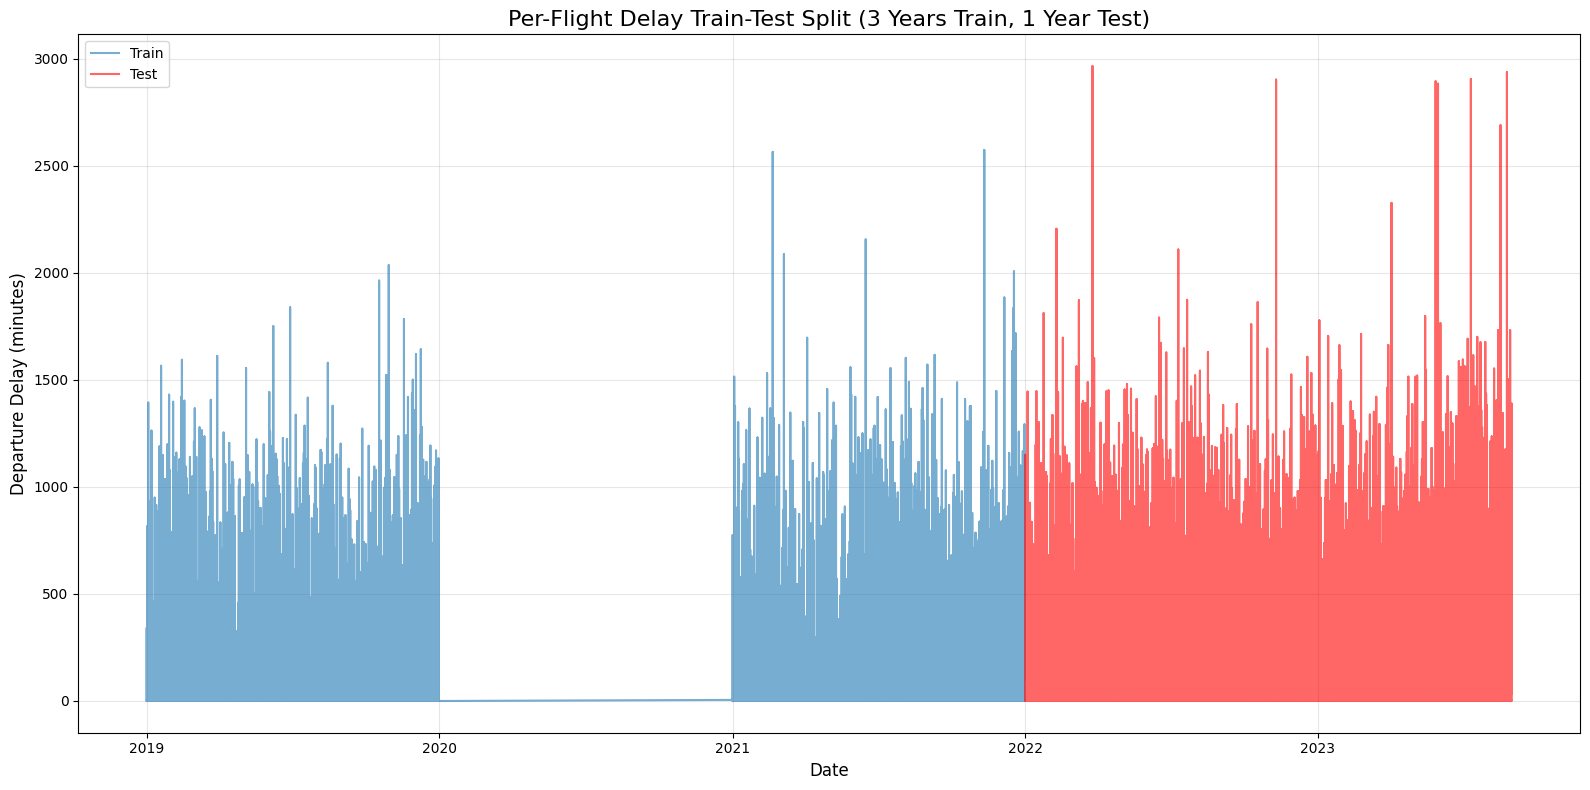

In [126]:
# --- Train/Test Split: 3 Years Train, 1 Year Test (Per-Flight Data) ---
# Load all base data in chunks and concatenate for per-flight granularity
all_chunks = []
for chunk in load_processed_data(BASE_PROCESSED_PATH):
    all_chunks.append(chunk)

# Concatenate all chunks
df_full = pd.concat(all_chunks, ignore_index=True)

# Drop rows where all columns are identical (full duplicates)
df_full = df_full.loc[~df_full.duplicated(keep='first')]
print(f"Full per-flight dataset size after dropping full duplicates: {len(df_full)} rows")

# Sort by FL_DATE for chronological split
if 'FL_DATE' in df_full.columns:
    df_full = df_full.sort_values('FL_DATE').reset_index(drop=True)
    min_date = df_full['FL_DATE'].min()
    train_end = min_date + pd.DateOffset(years=3)
    test_start = train_end
    test_end = df_full['FL_DATE'].max()
    train_flight = df_full[df_full['FL_DATE'] < train_end]
    test_flight = df_full[(df_full['FL_DATE'] >= test_start) & (df_full['FL_DATE'] <= test_end)]
    print(f"Train set: {len(train_flight)} rows from {train_flight['FL_DATE'].min()} to {train_flight['FL_DATE'].max()}")
    print(f"Test set: {len(test_flight)} rows from {test_flight['FL_DATE'].min()} to {test_flight['FL_DATE'].max()}")
else:
    print("FL_DATE column not found in per-flight data.")

# Output per-flight delay (FL_DATE, DEP_DELAY, and any other relevant columns)
per_flight_delay = df_full[['FL_DATE', 'DEP_DELAY']].copy()
per_flight_delay = per_flight_delay.sort_values('FL_DATE').reset_index(drop=True)
print(f"Final per-flight delay output shape: {per_flight_delay.shape}")
display(per_flight_delay.head())

# Save per-flight delay output
if 'save_ts_data' in globals():
    save_ts_data(per_flight_delay, "per_flight_delay_ts", TS_PROCESSED_PATH)
else:
    # Inline save logic if function is not defined yet
    os.makedirs(TS_PROCESSED_PATH, exist_ok=True)
    per_flight_delay.to_csv(os.path.join(TS_PROCESSED_PATH, "per_flight_delay_ts.csv"), index=False)
    per_flight_delay.to_pickle(os.path.join(TS_PROCESSED_PATH, "per_flight_delay_ts.pkl"))
    print(f"Saved per_flight_delay_ts to {TS_PROCESSED_PATH}")

# Visualize the per-flight train/test split
plt.figure(figsize=(16, 8))
plt.plot(train_flight['FL_DATE'], train_flight['DEP_DELAY'], label='Train', alpha=0.6)
plt.plot(test_flight['FL_DATE'], test_flight['DEP_DELAY'], label='Test', color='red', alpha=0.6)
plt.title('Per-Flight Delay Train-Test Split (3 Years Train, 1 Year Test)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Departure Delay (minutes)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# ...existing code for daily/aggregated splits and visualizations can remain below...

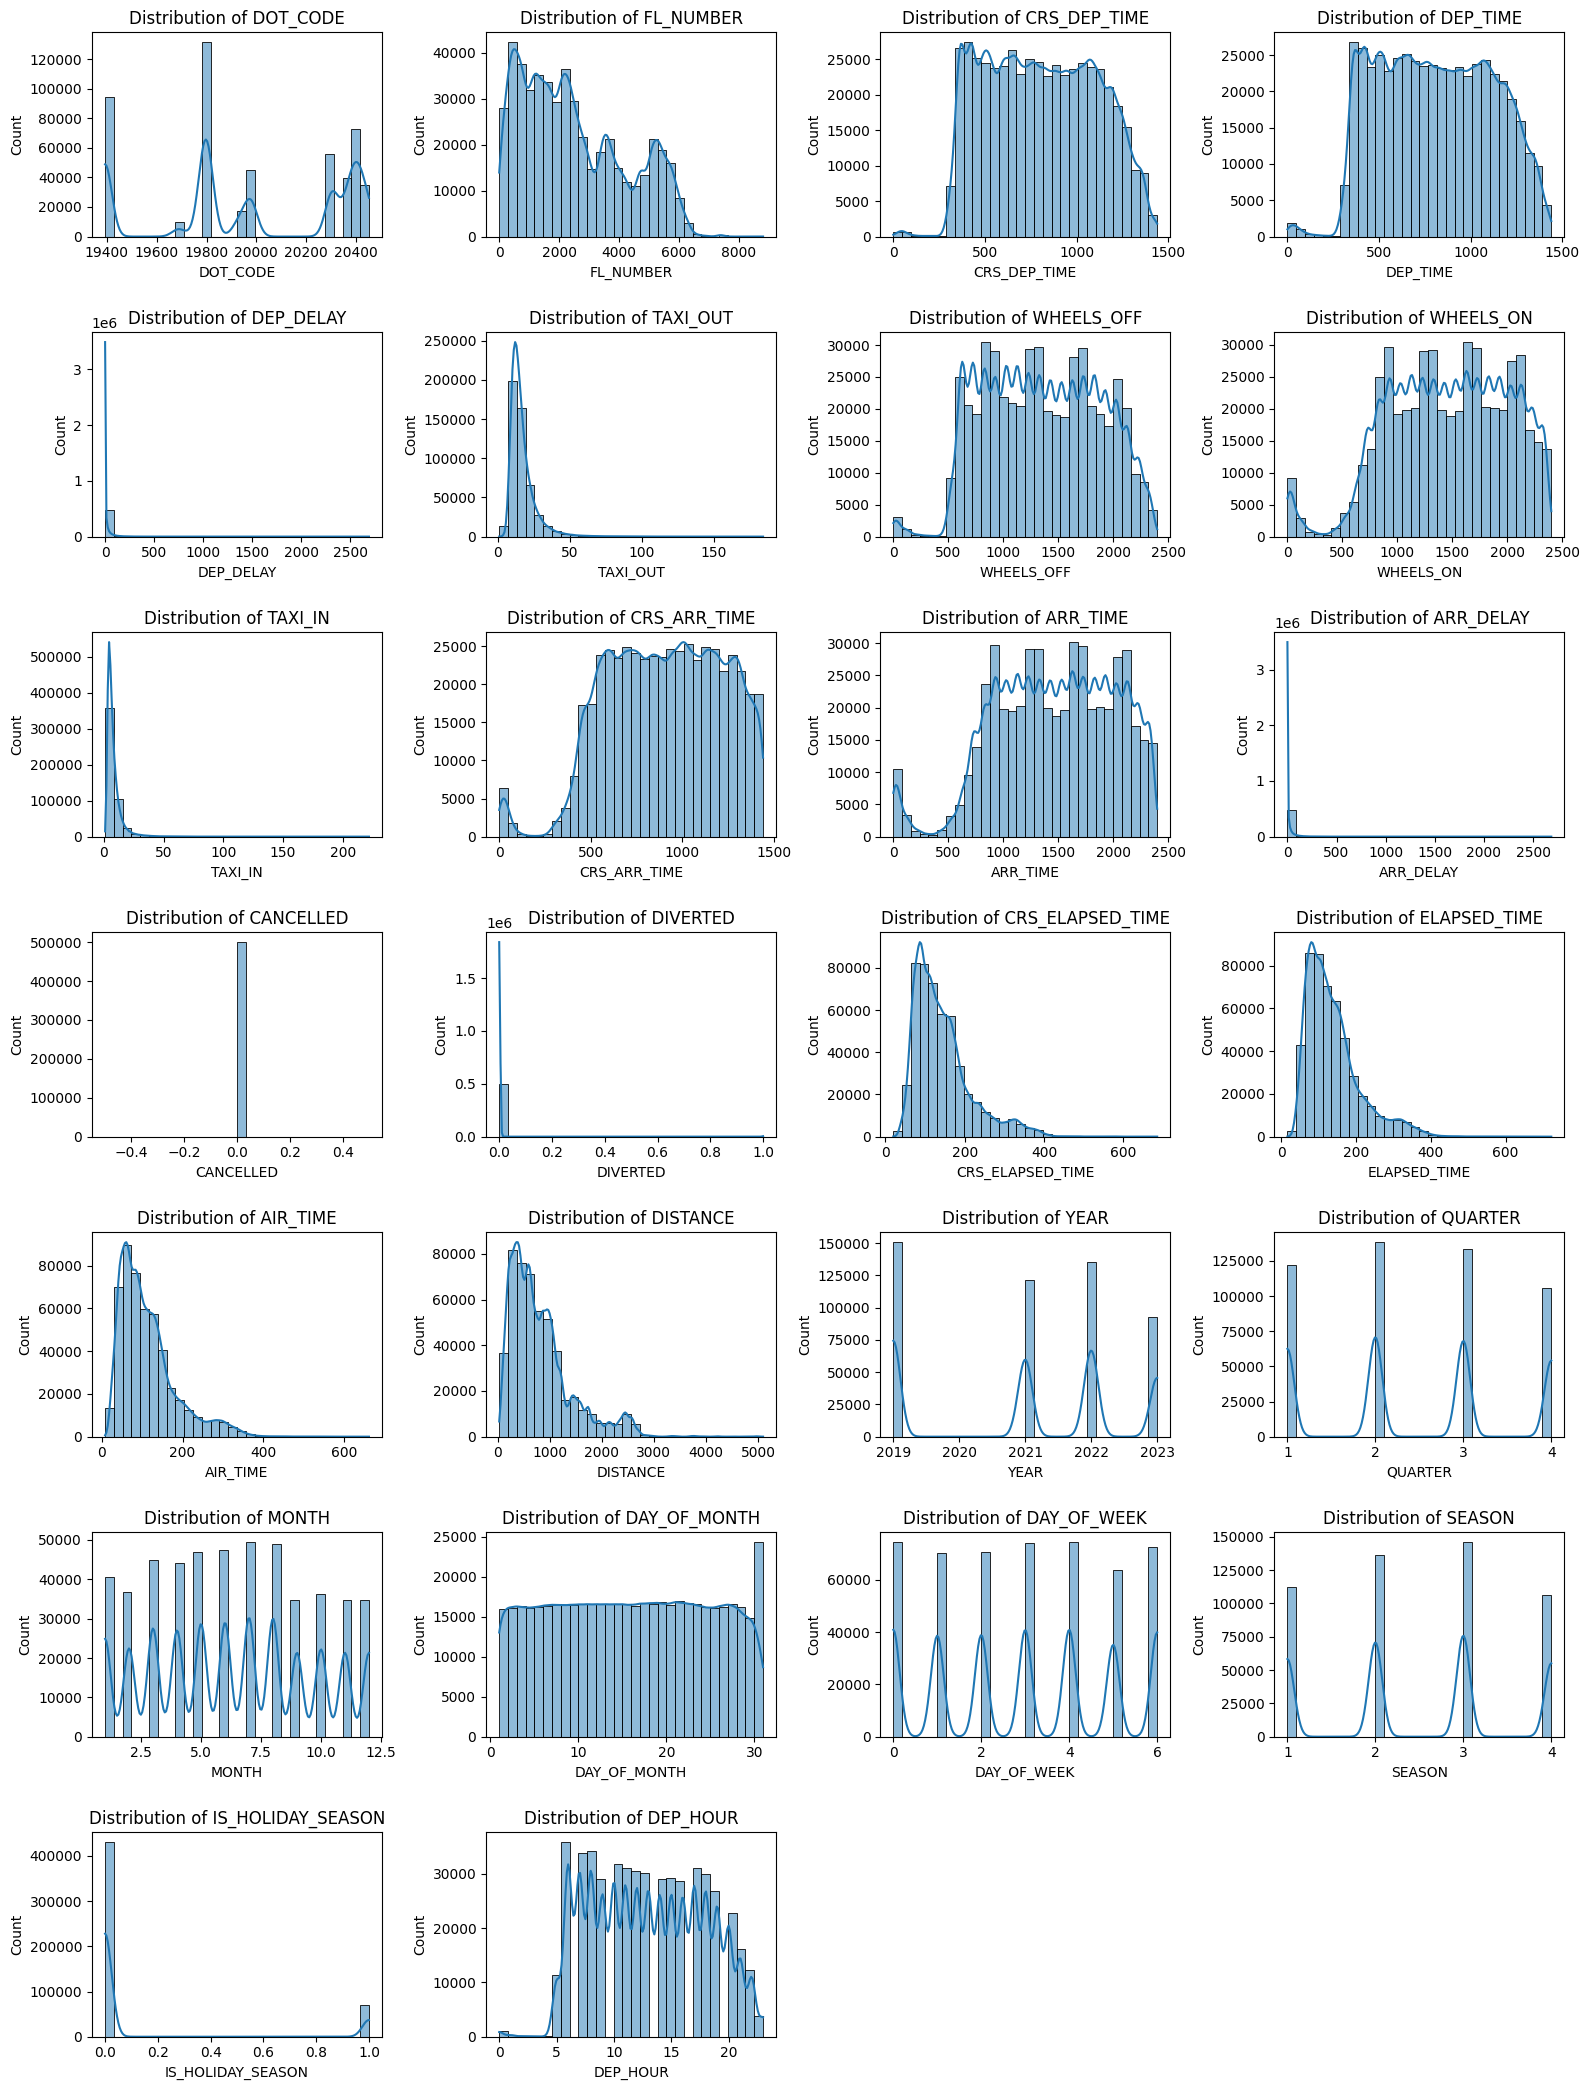

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

numeric_columns = df_imputed.select_dtypes(include=['int64', 'float64']).columns

n_cols = 4
n_rows = math.ceil(len(numeric_columns) / n_cols)

plt.figure(figsize=(n_cols * 4, n_rows * 3))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df_imputed[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


In [128]:
def find_binary_columns(df):
    """
    Identifies numerical columns that have only binary values (0 and 1).
    """
    binary_columns = []
    
    # Loop through all columns in the dataframe
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        # Check if unique values in the column are only 0 and 1
        if set(df[col].dropna().unique()) == {0, 1}:
            binary_columns.append(col)
    
    return binary_columns

# Example usage
binary_columns = find_binary_columns(df_imputed)
print("Binary columns:", binary_columns)


Binary columns: ['DIVERTED', 'IS_HOLIDAY_SEASON']


In [129]:
def check_unique_values_in_cat_columns(df):
    """
    Check the number of unique values in each categorical column.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame containing the data.
    
    Returns:
    --------
    dict
        A dictionary where the keys are the categorical column names and the values are the number of unique values.
    """
    # Select categorical columns (object dtype)
    cat_columns = df.select_dtypes(include=['object', 'category']).columns
    
    # Create a dictionary to store the count of unique values for each categorical column
    unique_values_dict = {}
    
    for col in cat_columns:
        unique_values_dict[col] = df[col].nunique()  # Count unique values in the column
    
    return unique_values_dict

# Example usage:
unique_values = check_unique_values_in_cat_columns(df_imputed)
print("\nUnique values in each categorical column:")
print(unique_values)



Unique values in each categorical column:
{'AIRLINE': 18, 'AIRLINE_DOT': 18, 'AIRLINE_CODE': 18, 'ORIGIN': 379, 'ORIGIN_CITY': 372, 'DEST': 377, 'DEST_CITY': 370, 'TIME_OF_DAY': 4}


## henaa lesaa el scaling bas haytzabat 


In [130]:
# from sklearn.preprocessing import OrdinalEncoder, StandardScaler
# import category_encoders as ce
# import numpy as np

# # ========== PIPELINE START ==========

# # Step 0: Drop irrelevant or never-used columns
# drop_cols = [
#   'ARR_DELAY', 'CANCELLED', 'AIRLINE_DOT', 'AIRLINE_CODE',
#             'DOT_CODE', 'FL_NUMBER', 'ORIGIN_CITY', 'DEST_CITY',
#             'CANCELLATION_CODE', 'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DELAY_DUE_SECURITY'
# ]
# df_imputed.drop(columns=[col for col in drop_cols if col in df_imputed.columns], inplace=True)

# # Step 1: Add holiday indicators
# df_imputed = add_holiday_indicators(df_imputed)

# # Step 2: Add time series features (lags, calendar, etc.)
# df_imputed = create_ts_features(df_imputed)

# # Step 3: Convert HHMM time columns to cyclical features
# def convert_hhmm_to_minutes(hhmm):
#     hhmm = int(hhmm)
#     hours = hhmm // 100
#     minutes = hhmm % 100
#     return hours * 60 + minutes

# def add_cyclical_features(df, time_columns):
#     for col in time_columns:
#         minutes = df[col].dropna().apply(convert_hhmm_to_minutes)
#         df[f'{col}_sin'] = np.sin(2 * np.pi * minutes / 1440)
#         df[f'{col}_cos'] = np.cos(2 * np.pi * minutes / 1440)
#     df.drop(columns=time_columns, inplace=True)
#     return df

# time_cols = ['CRS_DEP_TIME', 'DEP_TIME', 'CRS_ARR_TIME', 'ARR_TIME', 'WHEELS_ON', 'WHEELS_OFF']
# df_imputed = add_cyclical_features(df_imputed, time_cols)

# # Step 4: Convert binary columns to True/False
# df_imputed['DIVERTED'] = df_imputed['DIVERTED'].astype(bool)
# df_imputed['IS_HOLIDAY_SEASON'] = df_imputed['IS_HOLIDAY_SEASON'].astype(bool)

# # Step 5: Encode TIME_OF_DAY using ordinal encoding
# time_enc = OrdinalEncoder()
# df_imputed['TIME_OF_DAY'] = time_enc.fit_transform(df_imputed[['TIME_OF_DAY']])

# # Step 6: One-hot encode AIRLINE
# df_imputed = pd.get_dummies(df_imputed, columns=['AIRLINE'], drop_first=True)

# # Step 7: Binary encode ORIGIN and DEST
# binary_enc = ce.BinaryEncoder(cols=['ORIGIN', 'DEST'])
# df_imputed = binary_enc.fit_transform(df_imputed)

# # Step 8: One-hot encode binary columns
# df_imputed = pd.get_dummies(df_imputed, columns=['DIVERTED', 'IS_HOLIDAY_SEASON'], drop_first=True)

# # Step 9: Scale numeric columns (including lag features)
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline

# numeric_cols = df_imputed.select_dtypes(include=['int64', 'float64']).columns.tolist()
# scaler = StandardScaler()
# df_imputed[numeric_cols] = scaler.fit_transform(df_imputed[numeric_cols])

# # Final output
# print("✅ Full preprocessing pipeline completed.")
# # ========== PIPELINE END ==========


In [131]:
# # --- Train/Test/Validation Split for Daily Time Series (3 Years Train, 1 Year Test) ---
# # Ensure the index is a DatetimeIndex
# if not isinstance(ts_daily_featured.index, pd.DatetimeIndex):
#     ts_daily_featured.index = pd.to_datetime(ts_daily_featured.index)

# # Sort by date
# ts_sorted = ts_daily_featured.sort_index()
# min_date = ts_sorted.index.min()
# max_date = ts_sorted.index.max()

# # Define split points
# train_end = min_date + pd.DateOffset(years=3)
# test_start = train_end
# # Test set is 1 year after train_end, or up to max_date
# if test_start + pd.DateOffset(years=1) <= max_date:
#     test_end = test_start + pd.DateOffset(years=1) - pd.Timedelta(days=1)
# else:
#     test_end = max_date

# # Optionally, define validation as last 3 months of train
# val_days = 90
# val_start = train_end - pd.Timedelta(days=val_days)

# train_ts = ts_sorted[ts_sorted.index < val_start]
# val_ts = ts_sorted[(ts_sorted.index >= val_start) & (ts_sorted.index < train_end)]
# test_ts = ts_sorted[(ts_sorted.index >= test_start) & (ts_sorted.index <= test_end)]

# print(f"Train set: {len(train_ts)} days from {train_ts.index[0].date()} to {train_ts.index[-1].date()}")
# print(f"Validation set: {len(val_ts)} days from {val_ts.index[0].date()} to {val_ts.index[-1].date()}")
# print(f"Test set: {len(test_ts)} days from {test_ts.index[0].date()} to {test_ts.index[-1].date()}")

# # Visualize the splits
# plt.figure(figsize=(16, 8))
# plt.plot(train_ts.index, train_ts['avg_delay'], label='Train')
# plt.plot(val_ts.index, val_ts['avg_delay'], label='Validation', color='orange')
# plt.plot(test_ts.index, test_ts['avg_delay'], label='Test', color='red')
# plt.title('Time Series Train-Validation-Test Split (3 Years Train, 1 Year Test)', fontsize=16)
# plt.xlabel('Date', fontsize=12)
# plt.ylabel('Average Delay (minutes)', fontsize=12)
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

## Airport-Level and Carrier-Level Time Series

For more granular forecasting, we'll also create aggregations at the airport and carrier level. This enables us to forecast delays for specific airports or carriers.

In [132]:
# # Create airport-level time series
# ts_airport = aggregate_to_time_series(load_processed_data(BASE_PROCESSED_PATH), agg_level='airport_daily')

# print(f"Airport-level time series shape: {ts_airport.shape}")
# print(f"Number of airports: {len(ts_airport.index.levels[1])}")
# print("\nFirst few rows:")
# display(ts_airport.head())

# # Get top airports by number of flights
# top_airports = ts_airport.groupby(level=1)['num_flights'].sum().nlargest(5)
# print("\nTop 5 airports by number of flights:")
# print(top_airports)

In [133]:
# # Create carrier-level time series
# try:
#     ts_carrier = aggregate_to_time_series(load_processed_data(BASE_PROCESSED_PATH), agg_level='carrier_daily')
#     if ts_carrier is not None:
#         print(f"Carrier-level time series shape: {ts_carrier.shape}")
#         print(f"Number of carriers: {len(ts_carrier.index.levels[1])}")
#         print("\nFirst few rows:")
#         display(ts_carrier.head())
#         # Get top carriers by number of flights
#         top_carriers = ts_carrier.groupby(level=1)['num_flights'].sum().nlargest(5)
#         print("\nTop 5 carriers by number of flights:")
#         print(top_carriers)
#     else:
#         print("Carrier-level time series could not be created. Check if required columns exist in the data.")
# except Exception as e:
#     print(f"Error creating carrier-level time series: {e}")

In [134]:
# def save_ts_data(ts_data, name, output_dir):
#     """
#     Save time series data in multiple formats
#     """
#     import os
#     os.makedirs(output_dir, exist_ok=True)
#     csv_path = os.path.join(output_dir, f"{name}.csv")
#     ts_data.to_csv(csv_path)
#     pickle_path = os.path.join(output_dir, f"{name}.pkl")
#     ts_data.to_pickle(pickle_path)
#     print(f"Saved {name} to:")
#     print(f"- CSV: {csv_path}")
#     print(f"- Pickle: {pickle_path}")
#     return csv_path, pickle_path

In [135]:
# # Visualize time series for top airports
# if 'ts_airport' in locals() and 'top_airports' in locals() and not ts_airport.empty and not top_airports.empty:
#     plt.figure(figsize=(16, 8))
#     # Get top 5 airports
#     top_5_airports = top_airports.index
#     # Create a 7-day moving average for each airport
#     for airport in top_5_airports:
#         try:
#             airport_data = ts_airport.xs(airport, level=1)
#             plt.plot(airport_data.index, 
#                      airport_data['avg_delay'].rolling(window=7).mean(), 
#                      label=airport)
#         except Exception as e:
#             print(f"Error plotting {airport}: {e}")
#     plt.title('7-Day Moving Average of Delays by Airport', fontsize=16)
#     plt.xlabel('Date', fontsize=12)
#     plt.ylabel('Average Delay (minutes)', fontsize=12)
#     plt.legend()
#     plt.grid(True, alpha=0.3)
#     plt.tight_layout()
#     plt.show()
# else:
#     print("Airport-level time series or top airports not available for plotting.")

# # Save the daily time series with features
# if 'ts_daily_featured' in locals() and not ts_daily_featured.empty:
#     save_ts_data(ts_daily_featured, "daily_delay_ts", TS_PROCESSED_PATH)
# else:
#     print("ts_daily_featured not available for saving.")

# # Save airport-level time series
# if 'ts_airport' in locals() and not ts_airport.empty:
#     save_ts_data(ts_airport, "airport_delay_ts", TS_PROCESSED_PATH)
# else:
#     print("ts_airport not available for saving.")

# # Save carrier-level time series
# if 'ts_carrier' in locals() and ts_carrier is not None and not ts_carrier.empty:
#     save_ts_data(ts_carrier, "carrier_delay_ts", TS_PROCESSED_PATH)
# else:
#     print("ts_carrier not available for saving.")

# # Save train-test-validation splits
# if 'train_ts' in locals() and 'val_ts' in locals() and 'test_ts' in locals():
#     if not train_ts.empty:
#         save_ts_data(train_ts, "train_ts", TS_PROCESSED_PATH)
#     if not val_ts.empty:
#         save_ts_data(val_ts, "val_ts", TS_PROCESSED_PATH)
#     if not test_ts.empty:
#         save_ts_data(test_ts, "test_ts", TS_PROCESSED_PATH)
# else:
#     print("Train/validation/test splits not available for saving.")

## Time Series Cross-Validation

For time series, standard cross-validation isn't appropriate. We'll implement time series-specific cross-validation strategies.

In [ ]:
# # Time series cross-validation function
# def ts_cross_validation(ts_data, n_splits=3, test_days=7, val_days=7):
#     """
#     Create time series cross-validation folds
    
#     Parameters:
#     -----------
#     ts_data : pandas.DataFrame
#         Time series data with DatetimeIndex
#     n_splits : int
#         Number of validation folds to create
#     test_days : int
#         Number of days to include in each test fold
#     val_days : int
#         Number of days to include in each validation fold
        
#     Returns:
#     --------
#     list of tuples
#         Each tuple contains (train, val, test) for a fold
#     """
#     # Sort the data by date
#     ts_sorted = ts_data.sort_index()
    
#     # Calculate the size of each fold
#     fold_size = test_days + val_days
    
#     # List to store the folds
#     folds = []
    
#     # Create folds
#     for i in range(n_splits):
#         # Calculate the end of this fold
#         fold_end = ts_sorted.index[-1] - pd.Timedelta(days=i*fold_size)
#         test_start = fold_end - pd.Timedelta(days=test_days)
#         val_start = test_start - pd.Timedelta(days=val_days)
        
#         # Create the train, validation, and test sets
#         test = ts_sorted[(ts_sorted.index > test_start) & (ts_sorted.index <= fold_end)]
#         val = ts_sorted[(ts_sorted.index > val_start) & (ts_sorted.index <= test_start)]
#         train = ts_sorted[ts_sorted.index <= val_start]
        
#         # Append to folds list
#         folds.append((train, val, test))
    
#     return folds

In [137]:
# Demonstrate time series cross-validation
cv_folds = ts_cross_validation(ts_daily_featured, n_splits=3)

# Visualize CV folds
plt.figure(figsize=(16, 12))

for i, (train, val, test) in enumerate(cv_folds):
    plt.subplot(len(cv_folds), 1, i+1)
    
    plt.plot(train.index, train['avg_delay'], label='Train', alpha=0.7)
    plt.plot(val.index, val['avg_delay'], label='Validation', color='orange')
    plt.plot(test.index, test['avg_delay'], label='Test', color='red')
    
    plt.title(f'Fold {i+1}: Train {train.index[0]} to {train.index[-1]}, '
              f'Val {val.index[0]} to {val.index[-1]}, Test {test.index[0]} to {test.index[-1]}', 
              fontsize=14)
    plt.ylabel('Avg Delay (min)', fontsize=12)
    
    if i == 0:
        plt.legend()
    
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

NameError: name 'ts_daily_featured' is not defined

## Create Model-Ready Data for Different Time Series Algorithms

Different time series models have different data format requirements. Let's prepare data specifically for:
1. ARIMA/SARIMA models
2. Prophet models
3. Neural network-based forecasting (e.g., LSTM)

lw hat leave it khaliha sarima informer n beats 


In [ ]:
# # Create data formatted for different time series algorithms

# # 1. Format for ARIMA/SARIMA
# def format_for_arima(ts_data, target_col='avg_delay'):
#     """Format data for ARIMA/SARIMA models"""
#     # Fix negative delays before formatting
#     ts_data = fix_negative_delays(ts_data)
    
#     # For ARIMA, we typically need just the target variable as a series
#     arima_data = ts_data[target_col].copy()
    
#     # For SARIMAX with exogenous variables, we can include other features
#     exog_cols = [col for col in ts_data.columns if col != target_col and
#                 col not in ['avg_delay_lag1', 'avg_delay_lag2', 'avg_delay_lag3']]  # Exclude lags
    
#     # Create exogenous variables dataframe
#     exog_data = ts_data[exog_cols].copy() if exog_cols else None
    
#     return arima_data, exog_data

# # 2. Format for Prophet
# def format_for_prophet(ts_data, target_col='avg_delay'):
#     """Format data for Facebook Prophet"""
#     # Fix negative delays before formatting
#     ts_data = fix_negative_delays(ts_data)
    
#     # Prophet requires a specific DataFrame format with 'ds' and 'y' columns
#     prophet_data = pd.DataFrame({
#         'ds': ts_data.index,
#         'y': ts_data[target_col]
#     })
    
#     # Add additional regressors (optional)
#     for col in ts_data.columns:
#         if col != target_col and 'lag' not in col:  # Exclude lags
#             prophet_data[col] = ts_data[col]
    
#     return prophet_data

# # 3. Format for ML-based forecasting (LSTM)
# def format_for_lstm(ts_data, target_col='avg_delay', seq_length=7):
#     """Format data for LSTM models"""
#     # Fix negative delays before formatting
#     ts_data = fix_negative_delays(ts_data)
    
#     # For LSTM, we need sequences of data
#     # Prepare the data
#     data = ts_data.copy()
    
#     # Create sequences
#     X = []
#     y = []
    
#     for i in range(len(data) - seq_length):
#         # Get sequence of features
#         features = data.iloc[i:i+seq_length].drop(columns=[target_col])
#         # Get target value (next day's value)
#         target = data.iloc[i+seq_length][target_col]
        
#         X.append(features.values)
#         y.append(target)
    
#     # Convert to numpy arrays
#     X = np.array(X)
#     y = np.array(y)
    
#     # Get feature names for reference
#     feature_names = data.drop(columns=[target_col]).columns
    
#     return X, y, feature_names

In [ ]:
# # Create model-ready data examples using per-flight delay (DEP_DELAY) as the target

# # Load per-flight delay data
# per_flight_delay_path = os.path.join(TS_PROCESSED_PATH, "per_flight_delay_ts.pkl")
# per_flight_delay = pd.read_pickle(per_flight_delay_path)

# # Ensure FL_DATE is datetime and set as index
# per_flight_delay['FL_DATE'] = pd.to_datetime(per_flight_delay['FL_DATE'])
# per_flight_delay = per_flight_delay.set_index('FL_DATE').sort_index()

# # Optionally, create features for per-flight delay (if needed for LSTM/Prophet)
# per_flight_delay_featured = create_ts_features(per_flight_delay.rename(columns={'DEP_DELAY': 'avg_delay'}))

# # Split per-flight delay data into train/test (3y train, 1y test)
# min_date_pf = per_flight_delay_featured.index.min()
# train_end_pf = min_date_pf + pd.DateOffset(years=3)
# test_start_pf = train_end_pf
# test_end_pf = per_flight_delay_featured.index.max()
# train_pf = per_flight_delay_featured[per_flight_delay_featured.index < train_end_pf]
# test_pf = per_flight_delay_featured[(per_flight_delay_featured.index >= test_start_pf) & (per_flight_delay_featured.index <= test_end_pf)]

# # 1. Format for ARIMA/SARIMA (using per-flight delay)
# arima_data_pf, arima_exog_pf = format_for_arima(train_pf, target_col='avg_delay')
# print(f"ARIMA data shape (per-flight delay): {arima_data_pf.shape}")
# if arima_exog_pf is not None:
#     print(f"ARIMA exogenous data shape: {arima_exog_pf.shape}")

# # 2. Format for Prophet (using per-flight delay)
# prophet_data_pf = format_for_prophet(train_pf, target_col='avg_delay')
# print(f"\nProphet data shape (per-flight delay): {prophet_data_pf.shape}")
# print("Prophet data columns:", prophet_data_pf.columns.tolist()[:10], "...")

# # 3. Format for LSTM (using per-flight delay)
# lstm_X_pf, lstm_y_pf, lstm_features_pf = format_for_lstm(train_pf, target_col='avg_delay')
# print(f"\nLSTM X shape (per-flight delay): {lstm_X_pf.shape}")
# print(f"LSTM y shape (per-flight delay): {lstm_y_pf.shape}")
# print(f"LSTM features: {len(lstm_features_pf)} columns")

ARIMA data shape (per-flight delay): (1345137,)
ARIMA exogenous data shape: (1345137, 31)

Prophet data shape (per-flight delay): (1345137, 29)
Prophet data columns: ['ds', 'y', 'avg_delay_roll_mean3', 'avg_delay_roll_std3', 'avg_delay_roll_max3', 'avg_delay_roll_min3', 'avg_delay_roll_mean7', 'avg_delay_roll_std7', 'avg_delay_roll_max7', 'avg_delay_roll_min7'] ...

LSTM X shape (per-flight delay): (1345130, 7, 34)
LSTM y shape (per-flight delay): (1345130,)
LSTM features: 34 columns


In [ ]:
# # Save model-ready data for per-flight delay

# def save_model_ready_data(data_dict, output_dir):
#     """Save model-ready data for different algorithms"""
#     # Create directory if it doesn't exist
#     os.makedirs(output_dir, exist_ok=True)
#     # Save each item in the dictionary
#     for name, data in data_dict.items():
#         file_path = os.path.join(output_dir, f"{name}.pkl")
#         with open(file_path, 'wb') as f:
#             pickle.dump(data, f)
#         print(f"Saved {name} to {file_path}")

# model_ready_data_pf = {
#     'arima_data_per_flight': arima_data_pf,
#     'arima_exog_per_flight': arima_exog_pf,
#     'prophet_data_per_flight': prophet_data_pf,
#     'lstm_data_per_flight': (lstm_X_pf, lstm_y_pf, lstm_features_pf)
# }
# save_model_ready_data(model_ready_data_pf, os.path.join(TS_PROCESSED_PATH, 'model_ready'))

Saved arima_data_per_flight to c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\model_ready\arima_data_per_flight.pkl
Saved arima_exog_per_flight to c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\model_ready\arima_exog_per_flight.pkl
Saved prophet_data_per_flight to c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\model_ready\prophet_data_per_flight.pkl
Saved lstm_data_per_flight to c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\model_ready\lstm_data_per_flight.pkl


## The above cells now use per-flight delay (DEP_DELAY) as the target variable for all model-ready data formats (ARIMA, Prophet, LSTM).